# Summary of step dependencies

* **Difficulty level**: easy to intermediate
* **Time need to lean**: 20 minutes or less
* **Key points**:  
  * A numerically indexed step by default depends on its previous steps
  * A step can depend on steps that generate statically defined outputs
  * A step can depend on steps with `named_outputs(name)`
  * A step can depend on the output of another step with `output_from(step)`
  * A step can depend on another step with `sos_step(step)`
  * A step can depend on steps of another workflow with `sos_step(workflow)`
  * A step can depend on another step that `share` a variable
  * A step can depend on a step that `provides` output through patten matching of file names

SoS provides a plethora of methods to build dependencies between steps. These dependencies creates DAGs of workflows based on which workflows are executed. These dependencies could be built statically before the execution of workflow, or be added during the execution of the workflow but the general idea is the same.

This tutorial summarizes how SoS steps are connected using very simple examples. The details of each method will be discussed later.

<div class="bs-callout bs-callout-primary" role="alert">
  <h4>Save and view DAGs of a workflow</h4>
    <ul>
        <li>Option <code>-d</code> saves the directed acyclic graphs (DAGs) in <code>.dot</code> format during the evolution of a workflow. Multiple workflows will be saved in the same output file for any change of the DAG.</li>
        <li>Magic <code>%preview</code> displays DAGs as an animation in which black, green, and blue presents <code>pending</code>, <code>running</code>, and <code>completed</code> statuses of the nodes. </li>
    </ul>
</div>

<div class="bs-callout bs-callout-info" role="alert">
    <h4>Tracing dependencies of existing targets (option <code>-T</code>) *</h4>
    <p>The <code>-T</code> (tracing) option forces SoS to trace and execute steps that produce an input or dependent target of a step, even if it already exists. We use this option in this tutorial to contruct the complete DAGs of workflows regardless the existence of intermediate files.
</div>

## Numerically indexed steps

If no `input` and `output` is defined, a step with numerically indexed step name will be executed after its previous step. Therefore, the following workflow will be executed sequentially in numeric order.

Executing step_1
Executing step_2
Executing step_3


> num.dot (845 B):

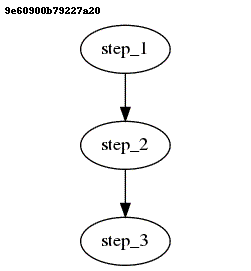

In [1]:
%preview -n num.dot
%run -v1 -d num.dot
[step_1]
print(f'Executing {step_name}')

[step_2]
print(f'Executing {step_name}')

[step_3]
print(f'Executing {step_name}')

## Depends on static output from another step

If the input of a step is not available, SoS will attempts to find another step that generates such a file and execute it before this step. A simple data-flow data workflow can therefore be written by defining static input and output of each step. The dependent files can also be specified in `depends:` statements.

Generating a.txt


> static.dot (1.9 KiB):

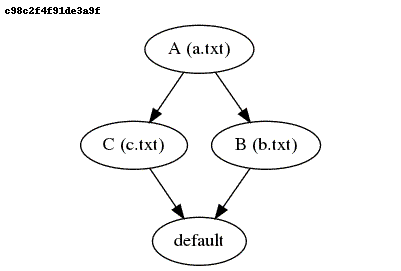

In [2]:
%preview -n static.dot

%run -v1 -T -d static.dot
[A]
output: 'a.txt'

_output.touch()
print(f'Generating {_output}')

[B]
input: 'a.txt'
output: 'b.txt'

_output.touch()
print(f'Generating {_output}')

[C]
input: 'a.txt'
output: 'c.txt'

_output.touch()
print(f'Generating {_output}')


[default]
input: 'b.txt', 'c.txt'

## Depends on named output

If there are multiple output or the output is not statically defined, function `named_output()` can be used to named output from another step. Basically, `name_output()` makes a step depends on another step with the named output. This function can also be used in `depends` statement.

> named.dot (1.6 KiB):

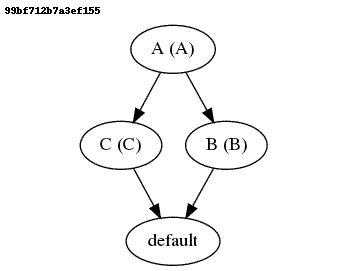

In [3]:
%preview -n named.dot

%run -v1 -T -d named.dot
[A]
output: A='a.txt'

_output.touch()
print(f'Generating {_output}')

[B]
input: named_output('A')
output: B='b.txt'

_output.touch()
print(f'Generating {_output}')

[C]
input: named_output('A')
output: C='c.txt'

_output.touch()
print(f'Generating {_output}')


[default]
input: named_output('B'), named_output('C')

## Depends on output from another step


Similar to `named_output`, function `output_from(step)` imports entire output from specified step, therefore creating a step-based dependency. This function can also be used in `depends:` statement.

> output_from.dot (1.6 KiB):

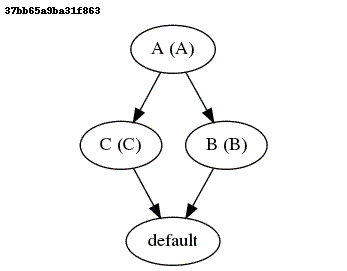

In [4]:
%preview -n output_from.dot

%run -v1 -d output_from.dot
[A]
output: 'a.txt'

_output.touch()
print(f'Generating {_output}')

[B]
input: output_from('A')
output: 'b.txt'

_output.touch()
print(f'Generating {_output}')

[C]
input: output_from('A')
output: C='c.txt'

_output.touch()
print(f'Generating {_output}')


[default]
input: output_from('B'), output_from('C')

## `Depends` on another step

If you simply want to execute another step before a step (for example if the step does not produce any output so you cannot use `output_from`), you can explicitly depend on another step using target `sos_step`. This allows you to build DAGs explicit without having to define input and output of each step.

Executing D


> sos_step.dot (1.5 KiB):

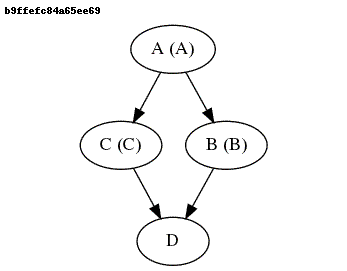

In [5]:
%preview -n sos_step.dot

%run D -v1 -T -d sos_step.dot
[A]
print(f'Executing {step_name}')

[B]
depends: sos_step('A')
print(f'Executing {step_name}')

[C]
depends: sos_step('A')
print(f'Executing {step_name}')

[D]
depends: sos_step('B'), sos_step('C')
print(f'Executing {step_name}')

## `Depends` on another workflow

Option for `sos_step()` can be a workflow name so you can explicitly execute another workflow before the execution of a step.

Executing A_1
Executing A_2
Executing D


> sos_step_wf.dot (1.9 KiB):

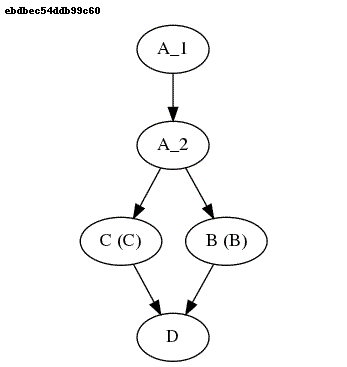

In [6]:
%preview -n sos_step_wf.dot
%run D -v1 -T -d sos_step_wf.dot
[A_1]
print(f'Executing {step_name}')

[A_2]
print(f'Executing {step_name}')

[B]
depends: sos_step('A')
print(f'Executing {step_name}')

[C]
depends: sos_step('A')
print(f'Executing {step_name}')

[D]
depends: sos_step('B'), sos_step('C')
print(f'Executing {step_name}')

## `Depends` on shared variable

If a step requires a certain variable `sos_variable()` that is shared by another step through step option `share`, the step that generates the variable will be executed before the step so that the variable can be passed.

Executing A
Executing D


> shared.dot (1.5 KiB):

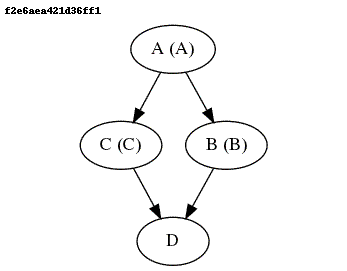

In [7]:
%preview -n shared.dot
%run D -v1 -T -d shared.dot
[A: shared='A']
A=100
print(f'Executing {step_name}')

[B]
depends: sos_variable('A')
print(f'Executing {step_name}')

[C]
depends: sos_variable('A')
print(f'Executing {step_name}')

[D]
depends: sos_step('B'), sos_step('C')
print(f'Executing {step_name}')

## Depends on pattern matched output

If none of the above method works, SoS looks for special steps that `provides` the required file through pattern-matching. Both `input:` and `depends:` statements can be used.

Generating a.txt
Executing D


> pattern.dot (2.1 KiB):

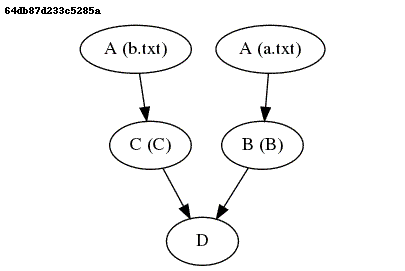

In [8]:
%preview -n pattern.dot
%run D -v1 -T -d pattern.dot

[A: provides='{filename}.txt']
_output.touch()
print(f'Generating {_output}')


[B]
input: 'a.txt'
print(f'Executing {step_name}')

[C]
input: 'b.txt'
print(f'Executing {step_name}')

[D]
depends: sos_step('B'), sos_step('C')
print(f'Executing {step_name}')

## Summary

As an interesting way to summaize this tutorial, let us look backward and see how a step can become a dependency to another step:

|Method | Syntax | Matched by | Comment |
| --- | -- | -- | -- |
| by step name | `[name]` | `depends: sos_step(name)` | `name` may or may not have index. Can only be in used `depends:` statement |
|      &nbsp;       |   &nbsp; | `input: output_from(name)` | Use output from step `name` |
|      &nbsp;       |   &nbsp; | `depends: output_from(name)` |&nbsp; |
|       &nbsp;       |  `[wfname_index]`   | `depends: sos_step(wfname)` | Match multiple steps (a workflow) with `wfname` |
| by static output | `output: 'output.txt' ` | `input: 'output.txt'` | Matching statically defined targets |
| &nbsp; | &nbsp; | `depends: 'output.txt'` | &nbsp;    |
| &nbsp; | `output: A='output.txt'` | `input: 'output.txt'` | named output can still be referred to directly |
| &nbsp; | &nbsp; | `depends: 'output.txt'` |  &nbsp; |
| by named output | `output: A='output.txt'` | `input: named_output('A')` | Name `A` can refer to multiple or dynamic outputs |
| &nbsp; | &nbsp; | `depends: named_output('A')` |&nbsp; |
| by shared variable | `[name: shared='var']` | `depends: sos_variable('var')` | The only way to exchange variables between steps |
| by pattern matching | `[name: provides='output.txt'] ` | `input: 'output.txt'` | Matching statically defined targets |
| &nbsp; | &nbsp; | `depends: 'output.txt'` | &nbsp; |
| &nbsp; | `[name: provides='{filename}.txt']` | `input: 'output.txt'` | pattern matching, only for file targets |
| &nbsp; | &nbsp; | `depends: 'output.txt'` | &nbsp;  |

Note that although we use `output.txt` as example for files, non-file targets are allowed in all cases where `output.txt` is used, except for the last case of `provides='{filename}.txt'` since pattern matching is available only for filenames. 